In [2]:
%clear
import tensorflow as tf
import numpy as np
import argparse
import socket
import importlib
import time
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestNeighbors

import scipy.misc
import sys
BASE_DIR = os.getcwd()
ROOT_DIR = os.path.dirname(BASE_DIR) +'/pointnet2-master'
sys.path.append(BASE_DIR)
sys.path.append(ROOT_DIR)
print('BASE_DIR =' ,BASE_DIR)
print('ROOT_DIR =' ,ROOT_DIR)
sys.path.append(os.path.join(ROOT_DIR, 'models'))
sys.path.append(os.path.join(ROOT_DIR, 'utils'))
sys.path.append(os.path.join(ROOT_DIR, 'part_seg'))
import provider
import modelnet_dataset
import modelnet_h5_dataset
import part_dataset_all_normal
import copy
import my_data_import as chao_data_import

BASE_DIR = /home/chaotang/文档/Try
ROOT_DIR = /home/chaotang/文档/pointnet2-master


# Define Utility function

In [3]:
def draw_pointcloud(batch_data):
    plt.figure()
    x,y,z = batch_data[:,0],batch_data[:,1],batch_data[:,2]
    ax = plt.subplot(111, projection='3d' )  # 创建一个三维的绘图工程
    ax.scatter(x,y,z,c = 'r',s = 1)
def get_batch(dataset, idxs, start_idx, end_idx):
    bsize = end_idx-start_idx
    batch_data = np.zeros((bsize, NUM_POINT, 6))
    batch_label = np.zeros((bsize, NUM_POINT), dtype=np.int32)
    for i in range(bsize):
        ps,normal,seg = dataset[idxs[i+start_idx]]
        batch_data[i,:,0:3] = ps
        batch_data[i,:,3:6] = normal
        batch_label[i,:] = seg
    return batch_data, batch_label

MODEL_PATH /home/chaotang/文档/pointnet2-master/part_seg/log_part_withoutNorm/model.ckpt
Airplane [0, 1, 2, 3]
Bag [4, 5]
Cap [6, 7]
Car [8, 9, 10, 11]
Chair [12, 13, 14, 15]
Earphone [16, 17, 18]
Guitar [19, 20, 21]
Knife [22, 23]
Lamp [24, 25, 26, 27]
Laptop [28, 29]
Motorbike [30, 31, 32, 33, 34, 35]
Mug [36, 37]
Pistol [38, 39, 40]
Rocket [41, 42, 43]
Skateboard [44, 45, 46]
Table [47, 48, 49]


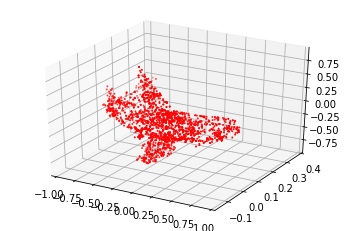

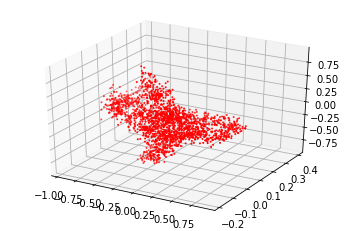

In [4]:
BATCH_SIZE = 16
NUM_POINT = 2048
PART_SEG_DIR = ROOT_DIR + '/part_seg'
MODEL_PATH = PART_SEG_DIR + '/log_part_withoutNorm/model.ckpt'
print('MODEL_PATH',MODEL_PATH)

GPU_INDEX =0
MODEL = importlib.import_module('pointnet2_part_seg') # import network module

DATA_PATH = os.path.join(ROOT_DIR, 'data', 'shapenetcore_partanno_segmentation_benchmark_v0_normal')
TEST_DATASET = part_dataset_all_normal.PartNormalDataset(root=DATA_PATH, npoints=NUM_POINT,
                                                         classification=False, split='test') # 每次重载都会shuffle掉
test_idxs = np.arange(0, len(TEST_DATASET))
plane_num = 8

# Get Train data
batch_data = np.zeros((BATCH_SIZE, NUM_POINT, 6))
batch_label = np.zeros((BATCH_SIZE, NUM_POINT)).astype(np.int32)
batch_data,batch_label = get_batch(TEST_DATASET,test_idxs,0,16)#batch_data = (16,2048,6)



Original_pl = batch_data[plane_num][:,0:3]
Nosise_batch = np.zeros((BATCH_SIZE, NUM_POINT, 6))
Nosise_batch = copy.copy(batch_data)


Nosise_batch[plane_num,...,0:3] += 0.025 * np.random.normal(size = (NUM_POINT,3))# Noisy的点云
Noise_pc = Nosise_batch[plane_num]
draw_pointcloud(Original_pl)
draw_pointcloud(Noise_pc)

MODEL_PATH /home/chaotang/文档/pointnet2-master/part_seg/log_part_withoutNorm/model.ckpt
cur_batch_data shape (16, 2048, 3)


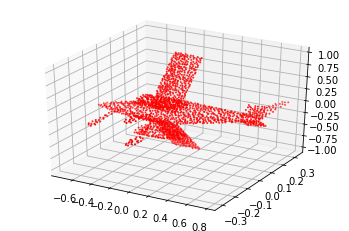

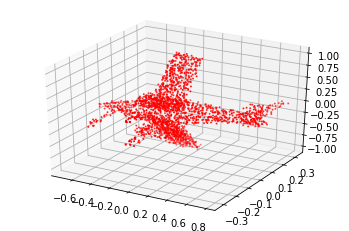

In [5]:
BATCH_SIZE = 16
NUM_POINT = 2048
PART_SEG_DIR = ROOT_DIR + '/part_seg'
MODEL_PATH = PART_SEG_DIR + '/log_part_withoutNorm/model.ckpt'
print('MODEL_PATH',MODEL_PATH)

GPU_INDEX =0
MODEL = importlib.import_module('pointnet2_part_seg') # import network module

plane_num = 2
# Get my data
cur_batch_data = np.zeros((BATCH_SIZE,NUM_POINT,3))
cur_batch_label = np.zeros((BATCH_SIZE), dtype=np.int32)
cur_batch_data,cur_batch_label = chao_data_import.get_data()
print('cur_batch_data shape',cur_batch_data.shape)

batch_data = np.zeros((BATCH_SIZE, NUM_POINT, 6))
batch_label = np.zeros((BATCH_SIZE, NUM_POINT)).astype(np.int32)
batch_data[:,:,0:3] = cur_batch_data

Original_pl = cur_batch_data[plane_num]
Nosise_batch = np.zeros((BATCH_SIZE, NUM_POINT, 6))
Nosise_batch = copy.copy(batch_data)


Nosise_batch[plane_num,...,0:3] += 0.0125 * np.random.normal(size = (NUM_POINT,3))# Noisy的点云
Noise_pc = Nosise_batch[plane_num]
draw_pointcloud(Original_pl)
draw_pointcloud(Noise_pc)

[   3 1990 1300 2035 1054]


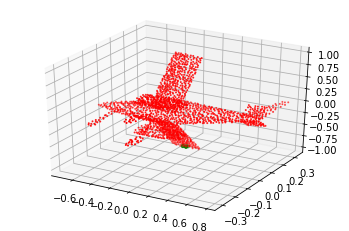

In [6]:
# Use KNN to find the nearest neighbours for each point
Neighbour = NearestNeighbors(n_neighbors=5, algorithm='kd_tree').fit(Original_pl)
distances, indices = Neighbour.kneighbors(Original_pl)
# The point Index you want to check in Plane(Plane_num)
check_point = 3
print(indices[check_point])# The indices tof the Nearest neighbour

t_x,t_y,t_z = Original_pl[indices[check_point],0],Original_pl[indices[check_point],1],Original_pl[indices[check_point],2]
x,y,z = Original_pl[:,0],Original_pl[:,1],Original_pl[:,2]

ax = plt.subplot(111, projection='3d' )  # 创建一个三维的绘图工程
ax.scatter(x,y,z,c = 'r',s = 1)
ax.scatter(t_x,t_y,t_z,c = 'g',s = 10)

In [7]:
tf.reset_default_graph()
##############################
#### Redefine the Graph#######
##############################
VOTE_NUM = 5
is_training = False

pointclouds_pl = tf.placeholder(dtype = tf.float32, shape=(BATCH_SIZE, NUM_POINT, 6))

labels_pl = tf.placeholder(tf.int32, shape=(BATCH_SIZE, BATCH_SIZE))
is_training_pl = tf.placeholder(tf.bool, shape=())

pred, end_points = MODEL.get_model(pointclouds_pl, is_training_pl)
saver = tf.train.Saver()

# Create a session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
with tf.Session(config=config) as sess:
    # Restore variables from disk.
    saver.restore(sess, MODEL_PATH)
    print('Model restored!!!!!')
    pred_val = np.zeros((BATCH_SIZE, NUM_POINT, 50))# (16*2048*50)
    pred_val2 = np.zeros((BATCH_SIZE, NUM_POINT, 50))# (16*2048*50)
    for _ in range(VOTE_NUM):
        feed = {pointclouds_pl:batch_data,is_training_pl:is_training}# No noise
        feed2 = {pointclouds_pl:Nosise_batch,is_training_pl:is_training}# Noise Feed in
        
        temp_pred_val,endpoints = sess.run([pred,end_points],feed_dict = feed)
        temp_pred_val2,endpoints2 = sess.run([pred,end_points],feed_dict = feed2)
        
        pred_val += temp_pred_val
        pred_val2 += temp_pred_val2
        
    pred_val /= float(VOTE_NUM)
    pred_val2 /= float(VOTE_NUM)
    
    feats = endpoints['feats']
    feats_0 = endpoints['feats_0']
    feats2 = endpoints2['feats']
    feats_02 = endpoints2['feats_0']
    print('Calculation Done!!!')


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /home/chaotang/文档/pointnet2-master/part_seg/log_part_withoutNorm/model.ckpt
Model restored!!!!!
Calculation Done!!!


In [9]:
print(pred_val[plane_num][indices[check_point]][:,0:4])# No Noise Condition
print('======================Noise Condition=======================')
print(pred_val2[plane_num][indices[check_point]][:,0:4])

[[-1.58380139  4.03546572 -4.58016634 -2.63403749]
 [-1.55149424  4.17440557 -4.57562113 -2.4983182 ]
 [-1.71035826  4.37770081 -5.13860369 -2.90122008]
 [-1.65642738  4.49827433 -5.01324272 -2.71312594]
 [-1.59871888  4.49939203 -4.80748367 -2.42635822]]
======================Noise Condition=======================
[[-3.45594454  2.31878209 -6.27400875 -4.33806372]
 [-3.37139606  2.377213   -6.19877195 -4.24432611]
 [-2.93664789  2.57865787 -5.52754211 -4.18765783]
 [-3.20590305  2.51143169 -5.94263029 -4.18995237]
 [-3.57159495  2.01741552 -6.30812454 -4.5734911 ]]


In [19]:
print('The shape of the feature = ',feats.shape)

np.savetxt('feats',feats[plane_num][indices[check_point]])

np.savetxt('feats_0',feats_0[plane_num][indices[check_point]])

np.savetxt('feats2',feats2[plane_num][indices[check_point]])

np.savetxt('feats_02',feats_02[plane_num][indices[check_point]])



The shape of the feature =  (16, 2048, 128)
